In [1]:
from typing import List
import re
from math import log
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import stim
import pymatching

In [2]:
def matching_graph(d: int, probabilities: List[float]) -> nx.Graph:
    """Get the matching graph for the repetition code.
    
    Arguments:
    d - Distance of the code. Should be odd.
    probabilities - A list of bit-flip probablities.
    
    Returns:
    M - The matching graph for this code and error model."""

    assert d >= 3, f"Distance must be >= 3, but got {d}."
    assert d % 2 != 0, f"Distance d must be odd, but got {d}."

    matching_graph = nx.Graph()
    # First add the "extra nodes" for the leftmost and rightmost qubits.
    matching_graph.add_node("r1")
    matching_graph.add_node("r2")
    # Then add the regular syndromes
    for i in range(d - 1):
        matching_graph.add_node(f"s{i}")
    # Add an edge of weight w = log((1-p_i)/p_i) for each qubit.
    for i in range(d):
        w = log((1. - probabilities[i]) / probabilities[i])
        if i == 0:
            matching_graph.add_edge("r1", "s0", weight=w, label="q0")
        elif i == d - 1:
            matching_graph.add_edge("r2", f"s{i-1}", weight=w, label=f"q{i}")
        else:
            matching_graph.add_edge(f"s{i-1}", f"s{i}", weight=w, label=f"q{i}")
    return matching_graph

In [3]:
def error_to_syndrome(err: np.ndarray) -> np.ndarray:
    """Convert a list of bit-flips into a the repetition code syndrome."""

    d = err.size
    check = np.zeros((d-1, d), dtype=bool)
    for i in range(d - 1):
        check[i, i] = True
        check[i, i + 1] = True
    return ((check.astype(int) @ err.astype(int)) % 2).astype(bool)

In [24]:
def syndrome_graph(matching: nx.Graph, syndrome: np.ndarray) -> nx.Graph:
    """Gets the syndrome graph for a binary syndrome vector given the
    matching graph."""

    d = len(matching.nodes()) - 1
    assert syndrome.size == d - 1

    syndrome_nodes: List[str] = []
    # Build a graph with a node for each 1 in the syndrome.
    # The weight between two nodes will be the distance on the matching graph.
    syndrome_gr = nx.Graph()
    for i, b in enumerate(syndrome):
        if b:
            syndrome_gr.add_node(f"s{i}")
    # If there is an odd number of ones in the syndrome,
    # we need to add in one of our "dummy" nodes because there is a flip
    # on the leftmost or rightmost bit.
    # Find the lowest and highest indices i such that syndrome[i] = 1.
    # If i_low < ((d-1) - i_high), then add the left dummy.
    # Else, then add the right dummy.
    if len(syndrome_gr.nodes()) % 2 != 0:
        for first_i in range(len(syndrome)):
            if syndrome[first_i]:
                break
        for last_i in range(len(syndrome) - 1, -1, -1):
            if syndrome[last_i]:
                break
        if first_i < abs(len(syndrome) - last_i):
            syndrome_gr.add_node("r1")
        else:
            syndrome_gr.add_node("r2")
    assert set(syndrome_gr.nodes()).issubset(matching.nodes())
    for sn1 in syndrome_gr.nodes():
        for sn2 in syndrome_gr.nodes():
            if sn1 != sn2:
                length = nx.shortest_path_length(matching, sn1, sn2, weight='weight')
                syndrome_gr.add_edge(sn1, sn2, weight=length)
    return syndrome_gr

In [25]:
def repetition_tanner_graph(d: int) -> nx.Graph:
    """Get the Tanner graph for a repetition code."""

    assert d % 2 != 0
    assert d >= 3

    tanner_graph = nx.Graph()
    for i in range(d):
        tanner_graph.add_node(f"q{i}")
        if i == 0:
            tanner_graph.add_node(f"r1")
            tanner_graph.add_node(f"s0")
            tanner_graph.add_edge("q0", "r1")
            tanner_graph.add_edge("q0", "s0")
        elif i == d - 1:
            tanner_graph.add_node("r2")
            tanner_graph.add_edge(f"q{i}", "r2")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
        else:
            tanner_graph.add_node(f"s{i}")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
            tanner_graph.add_edge(f"q{i}", f"s{i}")
    return tanner_graph

In [26]:
def matching_to_correction(matching, matching_gr, tanner_graph) -> np.ndarray:
    """Convert the minimum-weight matching to a binary correction."""

    def qubit_for_syndrome_pair(s1, s2):
        s1_neighbors = set(tanner_graph.neighbors(s1))
        s2_neighbors = set(tanner_graph.neighbors(s2))
        shared_nodes = s1_neighbors & s2_neighbors
        assert len(shared_nodes) == 1, f"{s1_neighbors} {s2_neighbors}"
        q_name = list(shared_nodes)[0]
        idx = int(re.search(r'\d+', q_name).group()) 
        return idx

    # Count qubits in the Tanner graph.
    nq = 0
    for node in tanner_graph.nodes():
        if 'q' in node:
            nq += 1

    correction = [False] * nq
    for n1, n2 in matching:
        # Get a path from n1 to n2 on the matching graph.
        # Each edge on the path will give us a qubit.
        path = nx.shortest_path(matching_gr, n1, n2)
        for i in range(len(path) - 1):
            s1 = path[i]
            s2 = path[i+1]
            idx = qubit_for_syndrome_pair(s1, s2)
            # correction[idx] = True
            correction[idx] ^= True
    return np.array(correction)

In [27]:
def syndrome_to_correction(syndrome: np.ndarray, probabilities: np.ndarray) -> np.ndarray:
    """Map a syndrome to a correction given an error model."""

    d = len(syndrome) + 1
    tanner_gr = repetition_tanner_graph(d)
    matching_gr = matching_graph(d, probabilities)
    syndrome_gr = syndrome_graph(matching_gr, syndrome)
    print("Syndrome graph nodes:\n", syndrome_gr.nodes)
    matching = nx.min_weight_matching(syndrome_gr)
    correction = matching_to_correction(matching, matching_gr, tanner_gr)
    
    # Check that the correction has the same syndrome as we passed in.
    correction_syndrome = error_to_syndrome(correction)
    if not np.array_equal(syndrome, correction_syndrome):
        raise ValueError(f"Correction {correction} has syndrome {correction_syndrome} but syndrome {syndrome} was passed.")

    return correction

In [28]:
d = 5
probs = [0.1] * d
err = np.array([1, 0, 1, 0, 0]).astype(bool)
syndrome = error_to_syndrome(err)
print(f"syndrome = {syndrome}")

tanner_graph = repetition_tanner_graph(d)
matching_gr = matching_graph(d, probs)
syndrome_gr = syndrome_graph(matching_gr, syndrome)
print(f"syndrome graph nodes: {syndrome_gr.nodes()}")
matching = nx.min_weight_matching(syndrome_gr)
print("matching =", matching)
correction = matching_to_correction(matching, matching_gr, tanner_graph)
print(f"correction = {correction}")
print(correction ^ err)

syndrome = [ True  True  True False]
syndrome graph nodes: ['s0', 's1', 's2', 'r1']
matching = {('s2', 's1'), ('r1', 's0')}
correction = [ True False  True False False]
[False False False False False]


In [29]:
p = 0.1 * np.ones(5)

for i1 in range(5):
    for i2 in range(5):
        if i1 != i2:
            err = np.zeros((5,), dtype=bool)
            err[i1] = True
            err[i2] = True
            syndrome = error_to_syndrome(err)
            print(err, syndrome)
            correction = syndrome_to_correction(syndrome, p)
            print(correction, correction ^ err)

[ True  True False False False] [False  True False False]
Syndrome graph nodes:
 ['s1', 'r1']
[ True  True False False False] [False False False False False]
[ True False  True False False] [ True  True  True False]
Syndrome graph nodes:
 ['s0', 's1', 's2', 'r1']
[ True False  True False False] [False False False False False]
[ True False False  True False] [ True False  True  True]
Syndrome graph nodes:
 ['s0', 's2', 's3', 'r1']
[ True False False  True False] [False False False False False]
[ True False False False  True] [ True False False  True]
Syndrome graph nodes:
 ['s0', 's3']
[False  True  True  True False] [ True  True  True  True  True]
[ True  True False False False] [False  True False False]
Syndrome graph nodes:
 ['s1', 'r1']
[ True  True False False False] [False False False False False]
[False  True  True False False] [ True False  True False]
Syndrome graph nodes:
 ['s0', 's2']
[False  True  True False False] [False False False False False]
[False  True False  True Fal

{'q0': Text(-0.368115800297698, 0.9421589328390769, 'q0'),
 'r1': Text(-0.6464047406208527, 1.0, 'r1'),
 's0': Text(-0.05668824115488528, 0.8160229163501106, 's0'),
 'q1': Text(0.22866594317862923, 0.6026871448193815, 'q1'),
 's1': Text(0.43839002108439773, 0.30165924561915763, 's1'),
 'q2': Text(0.5363080528472531, -0.05340824673727327, 'q2'),
 's2': Text(0.48849864039510743, -0.4113437316647312, 's2'),
 'q3': Text(0.29280160313405346, -0.7050294642754713, 'q3'),
 's3': Text(-0.006298605117318345, -0.8770786178423017, 's3'),
 'q4': Text(-0.3318419788131161, -0.8885768962879331, 'q4'),
 'r2': Text(-0.5753148946355707, -0.7270912828200154, 'r2')}

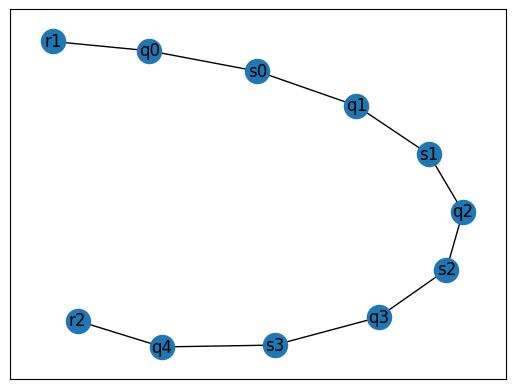

In [224]:
plt.figure()
pos = nx.spring_layout(tanner_graph)
nx.draw_networkx_nodes(tanner_graph, pos)
nx.draw_networkx_edges(tanner_graph, pos)
nx.draw_networkx_labels(tanner_graph, pos)

{'r1': Text(1.0, -0.01577007685011108, 'r1'),
 'r2': Text(-0.987875812411165, 0.15490173184442552, 'r2'),
 's0': Text(0.6390366778308886, -0.06510416022932443, 's0'),
 's1': Text(0.21389854207890585, -0.08022946411044059, 's1'),
 's2': Text(-0.22418225534392475, -0.039878783306909235, 's2'),
 's3': Text(-0.640877152154705, 0.04608075265235981, 's3')}

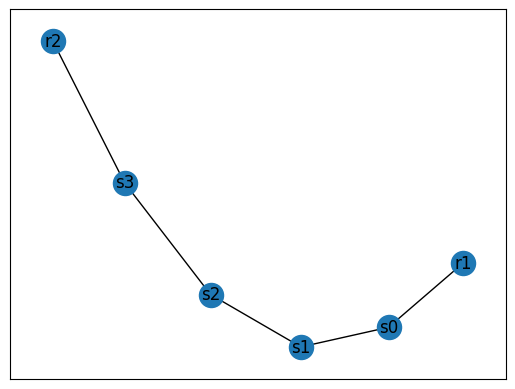

In [225]:
plt.figure()
pos = nx.spring_layout(matching_gr)
nx.draw_networkx_nodes(matching_gr, pos)
nx.draw_networkx_edges(matching_gr, pos)
nx.draw_networkx_labels(matching_gr, pos)

{'s0': Text(0.6649194388830432, -0.2695347669819012, 's0'),
 's1': Text(-0.6349617524667078, -0.9999995565748274, 's1'),
 's2': Text(0.6349607292751822, 1.0, 's2'),
 's3': Text(-0.6649184156915176, 0.2695343235567278, 's3')}

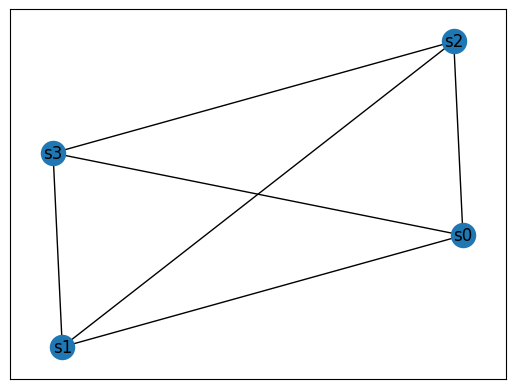

In [226]:
plt.figure()
pos = nx.spring_layout(syndrome_gr)
nx.draw_networkx_nodes(syndrome_gr, pos)
nx.draw_networkx_edges(syndrome_gr, pos)
nx.draw_networkx_labels(syndrome_gr, pos)

In [227]:
def repetition_code_circuit(d: int, p: float, prep_state: int = 0, depolarize: bool = False) -> stim.Circuit:
    """A single round of repetition code syndrome extraction proceeded by
    a bit-flip noise model on the data qubits."""

    assert d >= 3
    assert d % 2 != 0
    assert prep_state in set([0, 1])
    assert p >= 0. and p <= 1.

    data_qubits = list(range(0, 2 * d, 2))
    measure_qubits = list(range(1, 2 * d - 1, 2))

    ckt = stim.Circuit()
    for q in sorted(data_qubits + measure_qubits):
        ckt.append("R", q)
    # Prepare the 0 or 1 state.
    if prep_state == 1:
        ckt.append("X", [0])
        cnot_targets = []
        for i in range(1, len(data_qubits)):
            cnot_targets += [data_qubits[i-1], data_qubits[i]]
        ckt.append("CX", cnot_targets)
        ckt.append("TICK")
    # Add a round of noise.
    if depolarize:
        ckt.append("DEPOLARIZE1", data_qubits, arg=p)
    else:
        ckt.append("X_ERROR", data_qubits, arg=p)
    ckt.append("TICK")
    # Add a round of syndrome extraction and observable measurement.
    measure_targets = []
    for mq in measure_qubits:
        measure_targets += [mq-1, mq]
    ckt.append("CX", measure_targets)
    ckt.append("TICK")
    measure_targets = []
    for mq in measure_qubits:
        measure_targets += [mq+1, mq]
    ckt.append("CX", measure_targets)
    ckt.append("TICK")
    ckt.append("M", measure_qubits)
    # Add detectors for the syndrome measurments
    for i, mq in enumerate(measure_qubits):
        ckt.append_from_stim_program_text(f"DETECTOR({mq}, 0) rec[{-i - 1}]")
    # Add detectors and an observable for the data qubits.
    ckt.append("M", data_qubits)
    for i, dq in enumerate(data_qubits[:-1]):
        ckt.append_from_stim_program_text(f"DETECTOR({dq}, 1) rec[{-i - 2}] rec[{-i - 1}] rec[{-i - d - 1}]")
    ckt.append_from_stim_program_text(f"OBSERVABLE_INCLUDE(0) rec[-1]")
    return ckt

In [228]:
def count_logical_errors_pymatching(d: int, p:float, num_shots: int) -> int:
    circuit = repetition_code_circuit(d, p)

    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [229]:
def decode_batch(syndromes: np.ndarray, probabilities: np.ndarray) -> np.ndarray:
    """Get corrections for a batch of syndromes."""

    corrections = np.zeros((syndromes.shape[0], syndromes.shape[1] + 1), dtype=bool)
    for i, s in enumerate(syndromes):
        corrections[i, :] = syndrome_to_correction(s, probabilities)
    return corrections


def count_logical_errors_my_decoder(d: int, p: float, shots: int) -> int:
    """Sample syndromes from a stim circuit and return the number of logical errors
    according to my decoder."""

    circuit = repetition_code_circuit(d, p)
    probs = p * np.ones(d)
    sampler = circuit.compile_sampler()
    samples = sampler.sample(shots)
    syndromes = samples[:, :(d-1)]
    data_measurements = samples[:, (d-1):]

    num_errors = 0
    for i in range(shots):
        correction = syndrome_to_correction(syndromes[i, :], probs)
        c_xor_m = correction ^ data_measurements[i, :]
        if not (np.all(c_xor_m) or np.all(np.invert(c_xor_m))):
            raise ValueError(f"""The measurement and correction do not XOR to I or X.
            syndrome={syndromes[i, :]}
            data={data_measurements[i, :]}
            correction={correction}
            """)
        if np.all(c_xor_m):
            num_errors += 1
    return num_errors

In [230]:
shots = 10_000
ds = np.array([3, 5, 7])
ps = np.linspace(0.1, 0.5, num=7)
pymatching_lers = np.zeros((ds.size, ps.size))
my_lers = np.zeros((ds.size, ps.size))

for i, d in enumerate(ds):
    print(f"d={d}")
    for j, p in enumerate(ps):
        num_errors_pymatching = count_logical_errors_pymatching(d, p, shots)
        pymatching_lers[i, j] = float(num_errors_pymatching) / float(shots)
        num_errors_me = count_logical_errors_my_decoder(d, p, shots)
        my_lers[i,j] = float(num_errors_me) / float(shots)

d=3
d=5
d=7


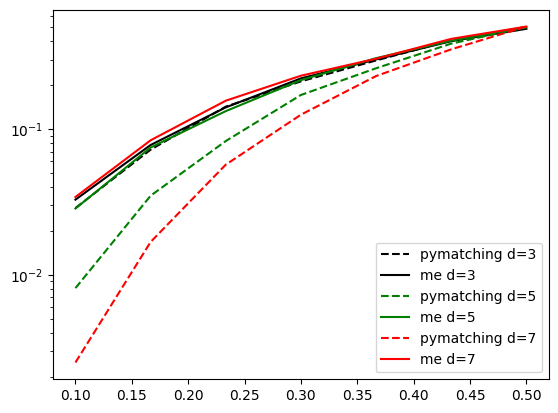

In [231]:
fig, ax = plt.subplots()
colors = ['k', 'g', 'r']
for i, (d, color) in enumerate(zip(ds, colors)):
    ax.plot(ps, pymatching_lers[i, :], '--', color=color, label=f"pymatching d={d}")
    ax.plot(ps, my_lers[i, :], '-', color=color, label=f"me d={d}")
ax.set_yscale('log')
plt.legend()